<a href="https://colab.research.google.com/github/bmutahhar/Keras-Text-Summarization/blob/main/Complete_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>**Machine Learning Course Project**</center>
## <center><b>Text Summarizer Using Keras</b></center>
---
### <center>Submitted by: Mutahhar bin Muzaffar<br>&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; FA17-BCS-058<center>

Since I'm making a `text summarizer` using `keras`. My first step towards the ultimate goal was a thorough preprocessing on the dataset.

I have used the Kaggle `food reviews` dataset to train my **LSTM** model. The dataset can be downloaded from [here](https://www.kaggle.com/snap/amazon-fine-food-reviews).

Below, I have explained the step by step preprocessing of the dataset.



Below, I am moving the required files from my directory to the default cwd of colab. contractions.json contains all possible contractions of words for example, wouldn't = would not etc. This is required to for data preprocessing.
The other file is attention.py which involves Attention Layer as keras does not provides attention layer by default.

In [ ]:
#Copying JSON file to the default working directory of this notebook.
!cp "/content/drive/My Drive/COMSATS University Islamabad/Semester 6/Machine Learning/Project/Code/contractions.json" "./"
#copy the attention.py file to default working directory
!cp "/content/drive/My Drive/Models/ML Project/attention.py" "./"

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd 
import re
import json
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from attention import AttentionLayer

Downloading stopwords from nltk library. These stop workds such as the articles, auxilary verbs and prepositions

In [ ]:
#Downloading stopwords from nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Reading the Dataset

The food reviews dataset consist of 568,454 food reviews of Amazon users left up to October 2012. The dataset span over multiple columns containing information about products, users, meta data about reviews, the reviews themselves, and the summaries of these reviews. 

In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/Datasets/Reviews.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


The dataset contains other information as well which is irrelevant to the scope of this project. Therefore, we have to drop other columns before proceeding with preprocessing.

In [ ]:
dataset = dataset.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time'], axis=1)
dataset = dataset.reset_index(drop=True)
dataset.head()


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
dataset.isnull().sum()

Summary    27
Text        0
dtype: int64

In [ ]:
dataset.drop_duplicates(subset=['Text'],inplace=True)
dataset.dropna(axis=0,inplace=True)

In [ ]:
dataset.isnull().sum()

Summary    0
Text       0
dtype: int64

Representation of some of the reviews and their summaries in the dataset.

In [ ]:
# Inspecting some of the reviews
for i in range(5):
    print("Review #{}".format(i+1))
    print("Summary: {}".format(dataset.Summary[i]))
    print("Actual Text: {}".format(dataset.Text[i]))
    print()

Review #1
Summary: Good Quality Dog Food
Actual Text: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Review #2
Summary: Not as Advertised
Actual Text: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

Review #3
Summary: "Delight" says it all
Actual Text: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion,

# Preparing the Data

The `contractions.json` file is locally compiled and contains the expanded forms of words like isn't, couldn't, won't etc.

In [ ]:
with open('./contractions.json','r') as f:
    contractions = json.load(f)


I defined this function so that I could apply this to the dataset and remove the stopwords from the `nltk` library and replace the compact words with their expanded forms as well as remove any special characters or unwanted html tags in the dataset.

In [ ]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    text = text.split()
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br >', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

After defining the function, I applied it to the reviews and summaries and allocated the cleaned reviews and summaries as new columns of the dataset.

In [ ]:
clear_summaries=[]
for summary in dataset.Summary:
    clear_summaries.append(clean_text(summary,remove_stopwords=False))

print("Summaries Cleaned!")

clear_texts = []
for text in dataset.Text:
    clear_texts.append(clean_text(text))
print("Texts Cleaned!")

Summaries Cleaned!
Texts Cleaned!


In [ ]:
dataset['Clear_text'] = clear_texts
dataset['Clear_summaries'] = clear_summaries

In the below cell, I inspected the starting 5 original and cleaned reviews along with their summaries.

In [ ]:
# Inspecting some of the reviews
for i in range(5):
    print("Review #{}".format(i+1))
    print("Actual Summary: {}".format(dataset.Summary[i]))
    print("Cleaned Summary: {}".format(dataset.Clear_summaries[i]))
    print("Actual Text: {}".format(dataset.Text[i]))
    print("Cleaned Summary: {}".format(dataset.Clear_text[i]))
    print()

Review #1
Actual Summary: Good Quality Dog Food
Cleaned Summary: good quality dog food
Actual Text: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Cleaned Summary: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better

Review #2
Actual Summary: Not as Advertised
Cleaned Summary: not as advertised
Actual Text: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
Cleaned Summary: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo

Review #3
Actual S

After removing the unwanted elements from the dataset, there is a high possibility that some of the rows may have become completely empty. So, just to be on the safe side, I replaced the empty values with NaN and then drop those values from the dataset using the `dropna` method of `pandas`.

In [ ]:
dataset.replace('',np.nan,inplace=True)
dataset.dropna(axis=0,inplace=True)

In [ ]:
dataset.reset_index(drop=True,inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392450 entries, 0 to 392449
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Summary          392450 non-null  object
 1   Text             392450 non-null  object
 2   Clear_text       392450 non-null  object
 3   Clear_summaries  392450 non-null  object
dtypes: object(4)
memory usage: 12.0+ MB


As you can see, after effective cleaning, the length of the dataset has become quite shortened.

## Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence.

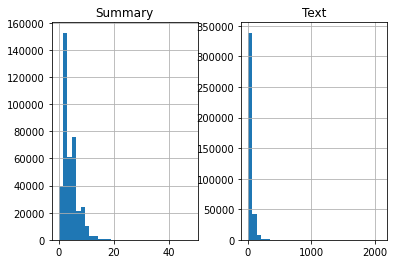

In [ ]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in dataset['Clear_text']:
      text_word_count.append(len(i.split()))

for i in dataset['Clear_summaries']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Text':text_word_count, 'Summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

From the above figures, we can estimate the maximum length of the summary to be 8 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries below 8.

In [ ]:
count=0
for i in dataset['Clear_summaries']:
    if(len(i.split())<=8):
        count+=1
print(count/len(dataset['Clear_summaries']))

0.9307325773983947


We observe that 93% of the summaries have length below 8. So, we can fix maximum length of summary to 8.

Let us fix the maximum length of review to 30

In [ ]:
max_text_len=30
max_summary_len=8

Let us refactor the dataset and select the reviews and summaries whose length falls below or equal to `max_text_len` and `max_summary_len` so that our model can be trained on optimized dataset.

In [ ]:
cleaned_text =np.array(dataset['Clear_text'])
cleaned_summary=np.array(dataset['Clear_summaries'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'Text':short_text,'Summary':short_summary})
df.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,looking secret ingredient robitussin believe f...,cough medicine
3,great taffy great price wide assortment yummy ...,great taffy
4,saltwater taffy great flavors soft chewy candy...,great just as good as the expensive brands


I have inserted the start and end token to our summaries. It is important as it helps in keeping track of the `tokenizer`.

In [ ]:
def sufficx_prefix(x):
    return "STARTOFTOKEN " + x + " ENDOFTOKEN"

In [ ]:
df['Summary'] = df.Summary.apply(sufficx_prefix)
print("Total texts after cleaning: {}".format(df.Text.count()))
print("Total summaries after cleaning: {}".format(df.Summary.count()))

Total texts after cleaning: 202538
Total summaries after cleaning: 202538


## Splitting the Dataset
---
Since all the cleaning part is done. I have divided the dataset into train and test set using the `train_test_split` method of sklearn library. We will be using 20% of the dataset from testing purposes while the rest of the dataset will be used to train the `Encoder` and `Decoder` model.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(df.Text),np.array(df.Summary),test_size=0.2,random_state=0,shuffle=True)

In [ ]:
print("Train set X size: ",X_train.shape)
print("Train set Y size: ",Y_train.shape)
print("Test set X size: ",X_test.shape)
print("Test set Y size: ",Y_test.shape)

Train set X size:  (162030,)
Train set Y size:  (162030,)
Test set X size:  (40508,)
Test set Y size:  (40508,)


In [ ]:
Y_train

array(['STARTOFTOKEN great cereal ENDOFTOKEN',
       'STARTOFTOKEN chocolate dessert ENDOFTOKEN',
       'STARTOFTOKEN my maltise loves it ENDOFTOKEN', ...,
       'STARTOFTOKEN addicting ENDOFTOKEN',
       'STARTOFTOKEN incredible ENDOFTOKEN',
       'STARTOFTOKEN lovely nougat ENDOFTOKEN'], dtype=object)

# Preparing the Tokenizer
Since an ML or DL model can work on only numeric values, it's necessory to convert text/strings into numerical values by the help of tokenizer. A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.So let's go ahead and build tokenizers for texts and summaries.

# Tokenizing ***Texts***

The reviews will acts as the X part of the dataset while their summaries will act as the Y portion. So first of all I have tokenized the texts column of our dataset which contains the actual reviews.

In [ ]:
#prepare a tokenizer for reviews on training data
X_tokenizer = Tokenizer() 
X_tokenizer.fit_on_texts(list(X_train))

## Rarewords and its Coverage
The dataset still contains rare words (words having lesser occurance than usual). These rare words may not prove to be useful in training our model. 
Let us look at the proportion rare words and its total coverage in the entire text

Here, I am defining the threshold to be 4 which means word whose count is below 4 is considered as a rare word



In [ ]:
threshold=4

count=0
total_count=0
frequency=0
total_frequency=0

for key,value in X_tokenizer.word_counts.items():
    total_count+=1
    total_frequency+=value
    if(value<threshold):
        count+=1
        frequency+=value
    
print("There are {}% of rare words in vocabulary.".format((count/total_count)*100))
print("Total Coverage of rare words: {}%".format((frequency/total_frequency)*100))

There are 65.14922995220394% of rare words in vocabulary.
Total Coverage of rare words: 1.4315355723174268%


As you can see we have almost 65% rare words in our vocabulary which covers a total of 1.4% area of our dataset. These rare words can become outliers which will produce inaccurate results in the future so they must be removed. 

Remember:

* `count` gives the no. of rare words whose count falls below threshold
* `total_count` gives the size of vocabulary (which means every unique words in the text)
* `total_count - count` gives the top most common words

Therefore, setting the total length of our tokenizer to `total_count - count` which is the normal and ususal words.



In [ ]:
#prepare a tokenizer for reviews on training data
X_tokenizer = Tokenizer(num_words=total_count-count) 
X_tokenizer.fit_on_texts(list(X_train))

#convert text sequences into integer sequences
X_train_seq = X_tokenizer.texts_to_sequences(X_train) 
X_test_seq = X_tokenizer.texts_to_sequences(X_test)

#padding zero upto maximum length
X_train = pad_sequences(X_train_seq,  maxlen=max_text_len, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
X_vocab = X_tokenizer.num_words + 1
X_vocab

16407

# Tokenizing ***Summaries***

Tokenizing the Y portion of the dataset and removing the rare words from summaries same as we did above. The only difference is that, for rare words in summaries I have set the threshold to 6, meaning any words occuring less than 6 times is a rare word.

In [ ]:
#prepare a tokenizer for reviews on training data
Y_tokenizer = Tokenizer()   
Y_tokenizer.fit_on_texts(list(Y_train))

In [ ]:
threshold=6

count=0
total_count=0
frequency=0
total_frequency=0

for key,value in Y_tokenizer.word_counts.items():
    total_count+=1
    total_frequency+=value
    if(value<threshold):
        count+=1
        frequency+=value
    
print("There are {}% of rare words in vocabulary.".format((count/total_count)*100))
print("Total Coverage of rare words: {}%".format((frequency/total_frequency)*100))

There are 76.29457364341086% of rare words in vocabulary.
Total Coverage of rare words: 2.845870496064023%


In [ ]:
#prepare a tokenizer for reviews on training data
Y_tokenizer = Tokenizer(num_words=total_count-count) 
Y_tokenizer.fit_on_texts(list(Y_train))

#convert text sequences into integer sequences
Y_train_seq = Y_tokenizer.texts_to_sequences(Y_train) 
Y_test_seq = Y_tokenizer.texts_to_sequences(Y_test)

#padding zero upto maximum length
Y_train = pad_sequences(Y_train_seq,  maxlen=max_summary_len, padding='post')
Y_test = pad_sequences(Y_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary ( +1 for padding token)
Y_vocab = Y_tokenizer.num_words + 1
Y_vocab

4588

Let us check whether word count of start token is equal to length of the training data

In [ ]:
Y_tokenizer.word_counts['startoftoken'],len(Y_train)

(162030, 162030)

Here, I am deleting the rows that contain only **START** and **END** tokens

In [ ]:
ind=[]
for i in range(len(Y_train)):
    cnt=0
    for j in Y_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

Y_train=np.delete(Y_train,ind, axis=0)
X_train=np.delete(X_train,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(Y_test)):
    cnt=0
    for j in Y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

Y_test=np.delete(Y_test,ind, axis=0)
X_test=np.delete(X_test,ind, axis=0)

# Model Building

To explain how LSTMs work, I am going to use the following image as a helping aid.
<figure>
<center>
  <img src="https://miro.medium.com/max/1382/1*DFPyZ-XMPFNukCP3mF8gJg.png" alt="LSTM Encoder Decoder"/>
  <figcaption>Fig 1: LSTM Encoder Decoder Model</figcaption>
  <center/>
</figure>
As you can see, each encoder and decoder models consists of several LSTM layers stacked over each other. We input our embedded words to the encoder and provides encoder's output to the decoder as it's input. Since each Lstm layers depends on the previous ones and the decoder depends on encoder's output, it is called Sequence to Sequence model.

* **Return Sequences = True**: We have set the return sequences to true so that the LSTM layers produces hidden state and cell stats for each time step.
* **Return State = True**: Setting the return state true makes the LSTM layers to output hidden and cell stat for last layer only.
* **Initial State**: This is used to initialize the internal states of the LSTM for the first timestep
* **Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence.

I have implemented 3 layers for encoder model and a single layer for our decoder model. I'll explain the architecture in much more detail in the video.

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(X_vocab, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#decoder embedding layer
dec_emb_layer = Embedding(Y_vocab, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)


decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])


#dense layer
decoder_dense =  TimeDistributed(Dense(Y_vocab, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)
print(decoder_outputs.shape)
# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()




(None, None, 4588)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      1640700     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)

In [ ]:
history=model.fit([X_train,Y_train[:,:-1]], Y_train.reshape(Y_train.shape[0],Y_train.shape[1], 1)[:,1:] ,epochs=30,callbacks=[es],batch_size=512, validation_data=([X_test,Y_test[:,:-1]], Y_test.reshape(Y_test.shape[0],Y_test.shape[1], 1)[:,1:]))

Epoch 1/30
312/312 [==============================] - 158s 507ms/step - loss: 3.1484 - val_loss: 2.8078
Epoch 2/30
312/312 [==============================] - 156s 500ms/step - loss: 2.7348 - val_loss: 2.6410
Epoch 3/30
312/312 [==============================] - 154s 493ms/step - loss: 2.5752 - val_loss: 2.4991
Epoch 4/30
312/312 [==============================] - 155s 495ms/step - loss: 2.4193 - val_loss: 2.3467
Epoch 5/30
312/312 [==============================] - 155s 496ms/step - loss: 2.2832 - val_loss: 2.2461
Epoch 6/30
312/312 [==============================] - 154s 494ms/step - loss: 2.1746 - val_loss: 2.1635
Epoch 7/30
312/312 [==============================] - 155s 496ms/step - loss: 2.0825 - val_loss: 2.1059
Epoch 8/30
312/312 [==============================] - 152s 488ms/step - loss: 2.0056 - val_loss: 2.0652
Epoch 9/30
312/312 [==============================] - 152s 488ms/step - loss: 1.9416 - val_loss: 2.0395
Epoch 10/30
312/312 [==============================] - 152s 486m

Below, you can see that as soon as the valdiation loss increase, `Early Stopping` mechanism kicked in and stopped the training here.

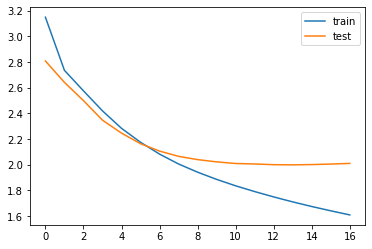

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Here, I have used the index_word dictionaries of our X and Y tokenizer so that we can eventually convert the predicted output sequence back into textual representation.

In [ ]:
reverse_target_word_index=Y_tokenizer.index_word
reverse_source_word_index=X_tokenizer.index_word
target_word_index=Y_tokenizer.word_index

# Inference

After training, the model is tested on new source sequences for which the target sequence is unknown. So, we need to set up the inference architecture to decode a test sequence. Here are the steps to decode the test sequence:

1. Encode the entire input sequence and initialize the decoder with internal states of the encoder
2. Pass <start> token as an input to the decoder
3. Run the decoder for one timestep with the internal states
4. The output will be the probability for the next word. The word with the maximum probability will be selected
5. Pass the sampled word as an input to the decoder in the next timestep and update the internal states with the current time step
6. Repeat steps 3 – 5 until we generate <end> token or hit the maximum length of the target sequence

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
decoder_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    458800      input_2[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 300)]        0                                            
_______________________________________________________________________________________

The method below takes an input sequence and feeds it to our encoder and then decoder model. The decoder model uses time steps and generates one word per step, this is why we have used a while loop which will iterate till the decoder predicts end token. 

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['startoftoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='endoftoken'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'endoftoken'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Below methods converts sequences back into actual text i.e reviews or summaries.

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['startoftoken']) and i!=target_word_index['endoftoken']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Finally, we have predicted at least 100 review samples from our test set and compared the result to the original summaries. Sinces there is no metrice for accuracy, we can check the accuracy of our model by comparing the actual vs predicted summaries. After seeing the results, we can say that our model did pretty well!

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(X_test[i]))
    print("Original summary:",seq2summary(Y_test[i]))
    print("Predicted summary:",decode_sequence(X_test[i].reshape(1,max_text_len)))
    print("\n")

Review: substantial bones must admit fun play taste incredibly delicious great way away afternoon lawn shade well assume true based dog reaction 
Original summary: delicious and fun for everyone 
Predicted summary:  my dog loves these


Review: best breadsticks ever wonderful crunchy sesame flavor fresh baked taste wonderful cheese soup alone local groceries stopped stocking mistake 
Original summary: great breadsticks 
Predicted summary:  great cheese


Review: use oil oil pulling light quite pleasant sunflower seed flavor exactly looking item arrived early nice surprise great seller 
Original summary: great for oil 
Predicted summary:  great oil


Review: omg wonderful replaced sugar house great smoothies sorts berries cereal love send gifts extended family easy thru amazon 
Original summary: sweet 
Predicted summary:  great product


Review: purchased item several years ago discovered comes china something want feed dog unless want catch bird flu 
Original summary: made in china 
Pr